In [1]:
import os
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
# Generate simulation data

# Gimbal control freq (in Hz)
gimbal_freq = 1000

# Actual freq on jetson (in Hz)
jetson_freq = 50

gimbal_t = np.linspace(0, 1, gimbal_freq)
jetson_t = np.linspace(0, 1, jetson_freq)

gt_gimbal_signal = np.sin(2 * np.pi * gimbal_t)

In [4]:
jetson_noise_std = 0.1

jetson_idx = np.round(np.linspace(0, gimbal_freq - 1, jetson_freq)).astype(int)
jetson_signal = gt_gimbal_signal[jetson_idx]

jetson_signal = jetson_signal + np.random.normal(scale=jetson_noise_std, size=jetson_signal.shape)

In [5]:
inter_func = scipy.interpolate.interp1d(jetson_t, jetson_signal, kind='previous')
extrapolated_signal = inter_func(gimbal_t)

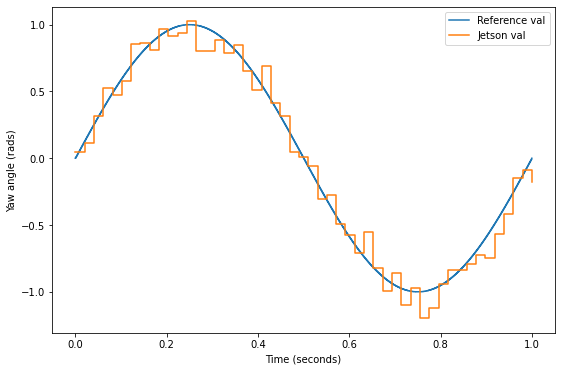

In [6]:
plt.figure(figsize=(9, 6))
plt.xlabel("Time (seconds)")
plt.ylabel("Yaw angle (rads)")
plt.step(gimbal_t, gt_gimbal_signal, label="Reference val", where='post')
plt.step(jetson_t, jetson_signal, label="Jetson val", where='post')
# plt.step(gimbal_t, extrapolate_jetson_signal, label="Extrapolated Jetson val")
plt.legend()

In [7]:
# Recursive variables
xhat = 0  # posterior
xhatminus = 0  # a priori

P = 0  # posterior variance estimation
Pminus = 0  # a priori variance estimation
K = np.array([0, 0])  # Kalman gain

# Constant modeling variables
Q = 1  # noise variance

H = 1

A = 1  # state transition
B = 0  # control transition

R = 20  # state variance

xhat_list = []

jetson_signal_ptr = 0

last_signal = 0
last_last_signal = 0

last_t = 0.1
last_last_t = -1

for i in range(gimbal_freq):
    if jetson_signal_ptr < len(jetson_t) and gimbal_t[i] >= jetson_t[jetson_signal_ptr]:
        last_last_signal = last_signal
        last_signal = jetson_signal[jetson_signal_ptr]
        last_last_t = last_t
        last_t = jetson_t[jetson_signal_ptr]
        jetson_signal_ptr += 1
    # state transition: A @ xhat + B @ u + N
    xhatminus = A * xhat + B
    Pminus = A*P*A + Q
    K = Pminus * H / (H * Pminus * H + R)
    
    # Update with pseudo posteriori observation
    xhat = xhatminus + K * (extrapolated_signal[i] - H * xhatminus)
    xhat_list.append(xhat)

In [8]:
xhat_arr = np.array(xhat_list)

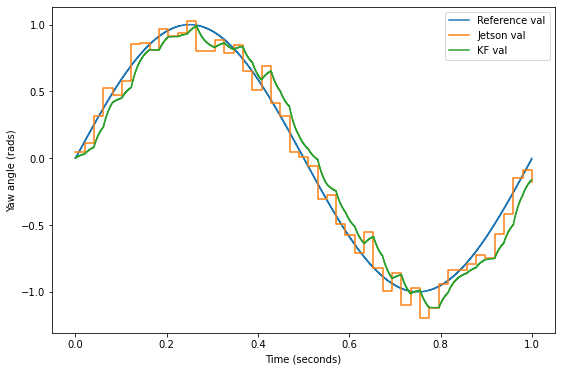

In [9]:
plt.figure(figsize=(9, 6))
plt.xlabel("Time (seconds)")
plt.ylabel("Yaw angle (rads)")
plt.step(gimbal_t, gt_gimbal_signal, label="Reference val", where='post')
plt.step(jetson_t, jetson_signal, label="Jetson val", where='post')
# plt.step(gimbal_t, extrapolate_jetson_signal, label="Extrapolated Jetson val")
plt.step(gimbal_t, xhat_arr, label="KF val", where='post')
plt.legend()